# Data loading

Training data is distributed in 3 different folders (set a, b and c).
Each file has its raw image (.mhd), lung mask (\_lm.mhd), and fissure mask (\_fm.mhd).

In [3]:
import os, random
import ntpath
import SimpleITK
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [4]:
workdir = '/projects/0/ismi2018/FINALPROJECTS/CHESTCT_FISSURE_INTEGRITY/'
train_A_images = os.path.join(workdir, 'set-a')
train_B_images = os.path.join(workdir, 'set-b')
train_C_images = os.path.join(workdir, 'set-c')

a02_lm.mhd
(171, 273, 445)


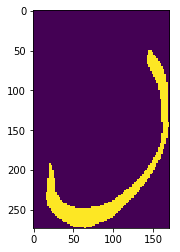

In [5]:
#Print one file:
case = os.path.join(train_A_images, random.choice(os.listdir(train_A_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.mhd'
img = SimpleITK.ReadImage(train_A_images+ '/' + case_filename)

piece = SimpleITK.GetArrayViewFromImage(img)[50,:,:] #<-- Specify a number for the z-index slice
print(case_filename)
print(img.GetSize())
plt.imshow(piece)


In [6]:
''' Helper function '''
def load_unique_image_names(folder):
    
    uniqueimglist = []
    for file in os.listdir(folder):
        file = file.replace(".mhd", "")
        file = file.replace("_lm", "")
        file = file.replace("_fm", "")
        file = file.replace(".zraw", "")
        if ".csv" not in file:
            uniqueimglist.append(file)
    uniqueimglist = list(set(uniqueimglist))
    return uniqueimglist


''' Load training data from a folder'''
def load_training_set(folder):
    fileList = load_unique_image_names(folder)
    
    trainSet = []
    for file in fileList:
        filePath = folder + '/' + file
        image = lungMask = fissureMask = None
        try:
            #imageRaw = SimpleITK.ReadImage(filePath + '.mhd')
            #lungMaskRaw = SimpleITK.ReadImage(filePath + '_lm.mhd')
            #fissureMaskRaw = SimpleITK.ReadImage(filePath + '_fm.mhd')
            #image = SimpleITK.GetArrayFromImage(imageRaw)
            #lungMask = SimpleITK.GetArrayFromImage(lungMaskRaw)
            #fissureMask = SimpleITK.GetArrayFromImage(fissureMaskRaw)
            image = filePath + '.mhd'
            lungMask = filePath + '_lm.mhd'
            fissureMask = filePath + '_fm.mhd'
            label = file[0]
            trainSet.append({'name': file, 
                         'image': image, 
                         'lungmask': lungMask,
                         'fissuremask': fissureMask,
                         'label': label})
        except :
            print("Error reading file: " + file)
            
    return trainSet

def get_exact_csv_set(folder, label):
    return pd.read_csv(folder + '/LUT-' + label + '.csv')
    


In [7]:
print("Loading train set...")
training = load_training_set(train_A_images)
training.extend(load_training_set(train_B_images))
training.extend(load_training_set(train_C_images))
training = pd.DataFrame(training)
print("Done loading!")

Loading train set...
Done loading!


Accessing the LUT csv files to attach the exact percentages to the training set:

In [8]:

exact = get_exact_csv_set(train_A_images, 'a') # 60
exact = exact.append(get_exact_csv_set(train_B_images, 'b'), ignore_index=True) # 38
exact = exact.append(get_exact_csv_set(train_C_images, 'c'), ignore_index=True) # 102
exact = exact.rename(columns={'Fissure_completeness': 'completeness'})

print("exact size: ", exact.size)
print("training size: ", training.size)

'''
emptyList = []
trainList = []
for el in training['name']:
    trainList.append(el)
    if el not in exact['New ID']:
        emptyList.append(el)
print(sorted(emptyList))
print(sorted(trainList))
print("Do the csv files represent the whole training set?")
print(sorted(trainList)== sorted(emptyList) )

exact['New ID'].iloc[31]
'''


# Join the csv set with the training set
training = pd.merge(training, exact, left_on='name', right_on='New ID')
training = training.drop('New ID', 1)


exact size:  200
training size:  500


In [13]:
#training['name'].head(5)

## Accessing the data

We attached the labels LUT-a.csv (etc...) to the training data in order to make it into a regression problem. Now, we would like to save this dataframe to file. Unfortunately, this can't be done, as the image elements aren't pickle-able (_Python can't pickle swigpy objects_).



- (Data) Raw images can be accessed by utilizing `training['image'].values`. This will return an array with the SimpleITK images.
- (Label) Classification labels _(a,b,c)_ can be obtained by `training['label'].values`.
- (Label) Regression labels _Fissure completeness percentage (%)_ can be obtained by `training['completeness'].values`.

Save the training set to file

*Actually can't be done, as it can't pickle swigpy objects..*

In [21]:
training['name'].head(1)
print("training shape: ", training.shape) 

training shape:  (100, 6)


Write to file:

In [10]:
training.to_pickle('./train-data-filelist.pkl')

Old code to load files itself:


Completeness:  79.6315


array([0, 2, 4], dtype=uint8)

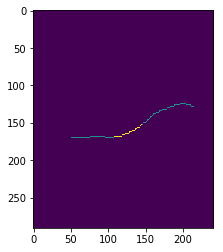

In [11]:
'''
img = training['fissuremask'].iloc[1]
piece = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(piece)
print("Completeness: ", training['completeness'].iloc[1])
np.unique(piece)
'''

Completeness:  69.0858


array([-1024, -1023, -1020, ...,  1330,  1340,  1353], dtype=int16)

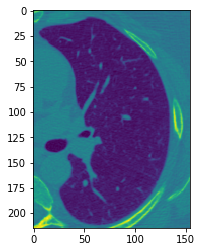

In [20]:
# Load image:
idx = 1

img = SimpleITK.ReadImage(training['image'][idx])
piece = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(piece)
print("Completeness: ", training['completeness'].iloc[1])
np.unique(piece)

#SimpleITK.ReadImage(filePath + '.mhd')


# Patch Generator